In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show code."></form>''')

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid',context="notebook",font_scale=1.2)

from utilis import permutation_sample, draw_perm_reps

import warnings
warnings.filterwarnings('ignore')

## **USP Sale Analysis**

## Data

In [3]:
data = pd.read_csv('USP Case Study.csv')
data.head()

,YEAR,RS_A,RS_B,RS_C,RS_D,RS_E,RS_F,CUST_ID
0,2017,122,529,50,159,168,98,LA_1001
1,2018,62,478,68,100,143,54,LA_1001
2,2019,39,489,42,70,162,33,LA_1001
3,2017,119,531,54,209,164,76,LA_1002
4,2018,60,456,47,236,160,34,LA_1002


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12645 entries, 0 to 12644
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   YEAR     12645 non-null  int64 
 1   RS_A     12645 non-null  int64 
 2   RS_B     12645 non-null  int64 
 3   RS_C     12645 non-null  int64 
 4   RS_D     12645 non-null  int64 
 5   RS_E     12645 non-null  int64 
 6   RS_F     12645 non-null  int64 
 7   CUST_ID  12645 non-null  object
dtypes: int64(7), object(1)
memory usage: 790.4+ KB


No missing values, one categorical variable (CLUST_ID).

Adding new categorical variable, Region

In [5]:
data['Region'] = data['CUST_ID'].apply(lambda x: x[:2])
data.head()

,YEAR,RS_A,RS_B,RS_C,RS_D,RS_E,RS_F,CUST_ID,Region
0,2017,122,529,50,159,168,98,LA_1001,LA
1,2018,62,478,68,100,143,54,LA_1001,LA
2,2019,39,489,42,70,162,33,LA_1001,LA
3,2017,119,531,54,209,164,76,LA_1002,LA
4,2018,60,456,47,236,160,34,LA_1002,LA


In [6]:
# Transforing data into vertical format
df = data.melt(id_vars=['YEAR','CUST_ID','Region'],value_name='Units',var_name='Drug')

## Average unit sale by region, year, & drug type

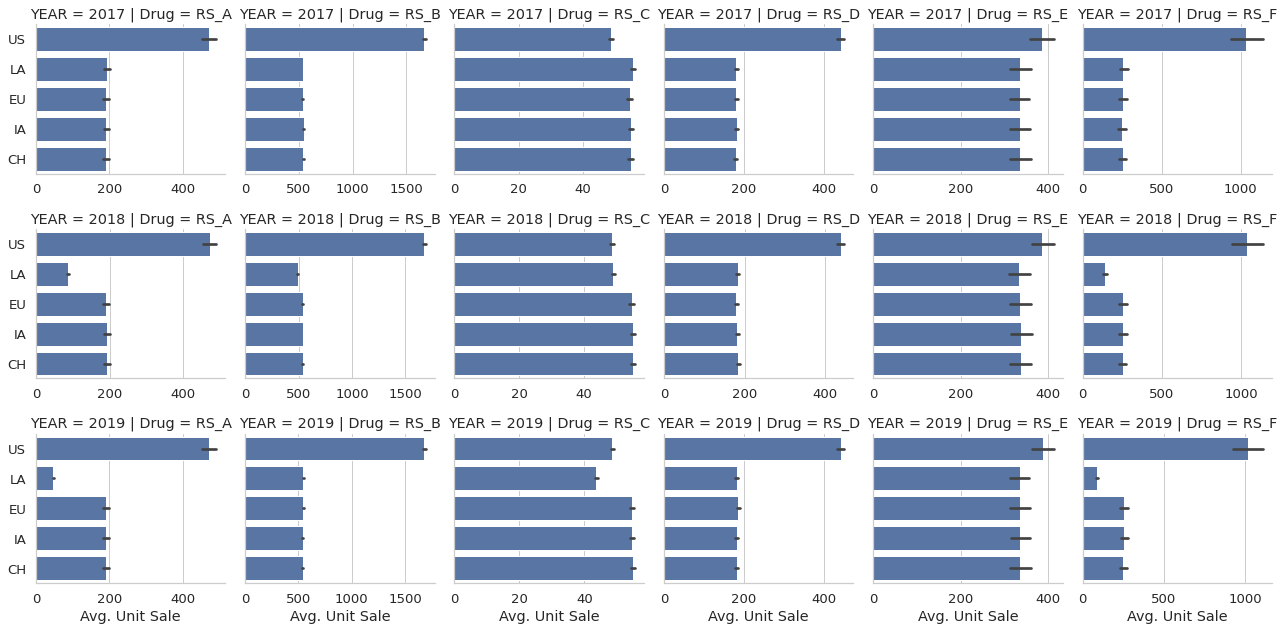

In [7]:
g = sns.FacetGrid(data=df,row='YEAR',col='Drug',sharex=False)
_=g.map_dataframe(sns.barplot,orient='h',x='Units',y='Region',order=['US','LA','EU','IA','CH'])
g.set_xlabels('Avg. Unit Sale')
g.tight_layout()
plt.savefig('fig.png',dpi=300)

## Share of unit sale by region for each year

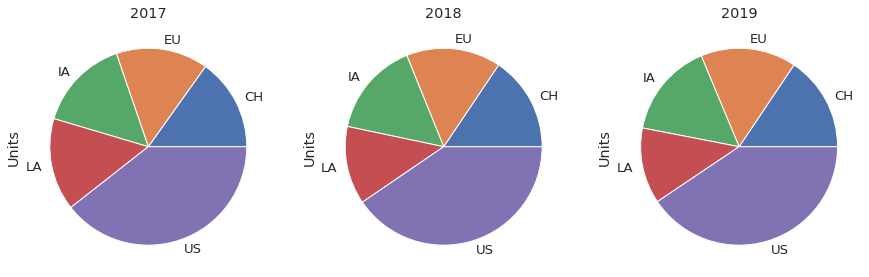

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))

for ii, year in enumerate([2017,2018,2019]):
    df[df['YEAR']==year].groupby(['Region'])['Units'].mean().plot.pie(title=year,ax=axes[ii])
    
plt.savefig('pie_chart.png',dpi=300)

## Sale of drug A, B, C, and F in LA

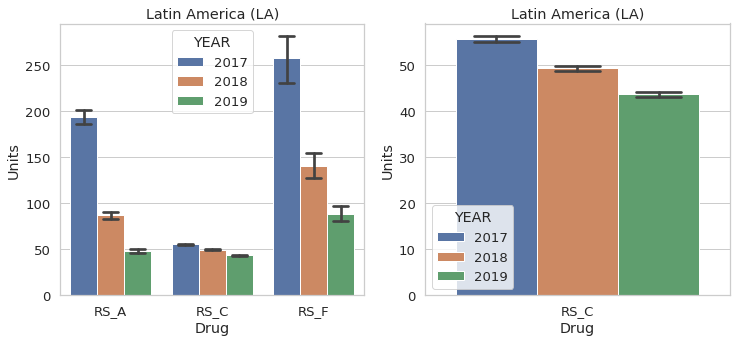

In [9]:
fig, axes = plt.subplots(ncols=2,figsize=(12,5))
sns.barplot(x='Drug',y='Units', 
              data = df[df['Drug'].isin(['RS_A','RS_C','RS_F']) & (df['Region'].isin(['LA']))],
              capsize=0.15,hue='YEAR',ax=axes[0])
axes[0].set_title('Latin America (LA)')

sns.barplot(x='Drug',y='Units', 
              data = df[df['Drug'].isin(['RS_C']) & (df['Region'].isin(['LA']))],
              capsize=0.15,hue='YEAR',ax=axes[1])
axes[1].set_title('Latin America (LA)')

_=plt.savefig('Drug_ACF.png',dpi=300)

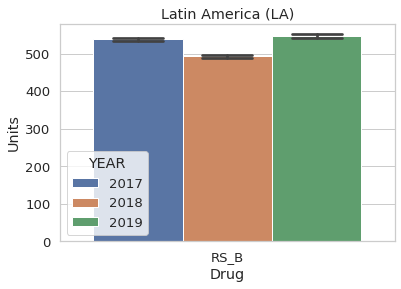

In [10]:
_=sns.barplot(x='Drug',y='Units', 
              data = df[df['Drug'].isin(['RS_B']) & (df['Region'].isin(['LA']))],
              capsize=0.15,hue='YEAR')
plt.title('Latin America (LA)')
_=plt.savefig('Drug_B.png',dpi=300)

Observation: 
   - There is a decline in the sale of drugs A, C, and F for the year 2018 and 2019 in Latin America (LA).
   - There was a decline in the sale of drug B in the year 2018. However in 2019, its sale improved and surpassed its 2017 mark.

 

Sale of other drugs has been consistent across years and regions.

# Permutation tests

Following permutation tests were performed to test if the decline (of A, B, C and F) or increase (of B in 2019) in sale between two years was significant. 

Notations:  
$\mu_{d, y}$: average unit sale of drug, $d$ for the year, $y$

In [16]:
n1 = '\n'
def myfunc(samp1, samp2):
    return np.mean(samp1) - np.mean(samp2)

def perm_test(df,region, drug, year1, year2, nperms):
    '''
    This function performs permutation test on whether the number durg units sold in year1 
    were significantly greater than those sold in year2
    
    H0: year1 = year2
    H1: year1 > year2
    '''
    
    y1_units = df[(df['Region']==region) & (df['Drug'] == drug) & (df['YEAR']==year1)]['Units']
    y2_untis = df[(df['Region']==region) & (df['Drug'] == drug) & (df['YEAR']==year2)]['Units']
    
    null = draw_perm_reps(y1_units,y2_untis,myfunc,size=nperms)
    
    obs = myfunc(y1_units,y2_untis)

    p_val = ((np.abs(null) > np.abs(obs)).sum() + 1)/(nperms+1)
    
    return p_val, null, obs

def test(df,region,drug,year1,year2,nperms=1000):
    '''
    This function performs permutation test on whether the number durg 
    units sold in year1 were significantly greater than those sold in year2, 
    and plots the simulated null distribution and observed difference.
    
    H0: year1 = year2
    H1: year1 > year2
    '''
    pval, null, obs = perm_test(df,region, drug, year1, year2, nperms=nperms)
    plt.hist(null,label='Null distribution')
    plt.axvline(obs,color='red',label='Observed Difference')
    plt.legend()
    drug = drug[-1]
    #_=plt.title(rf'{region}: {drug}{n1} H0: {year1} = {year2}{n1} H1: {year} $\neq$ {year2}')
    _=plt.title(rf'{region}: {drug}{n1} H0: $\mu{drug,year1}$ = $\mu{drug,year2}${n1} H1: $\mu{drug,year1} \neq \mu{drug,year2}$')
    plt.show()
    if pval < 0.025:
        print('Reject the null hypothesis (H0): p value = %.3f'%pval)
    else:
        print("Can't reject the null hypothesis (H0): p value = %.3f"%pval)

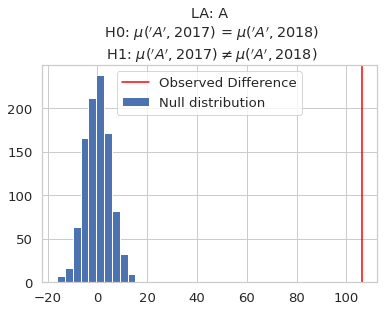

Reject the null hypothesis (H0): p value = 0.001


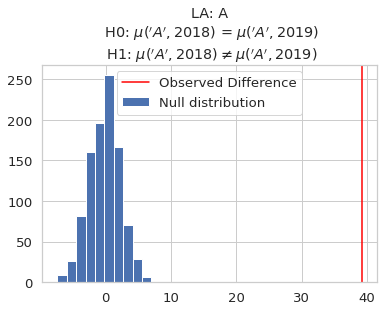

Reject the null hypothesis (H0): p value = 0.001


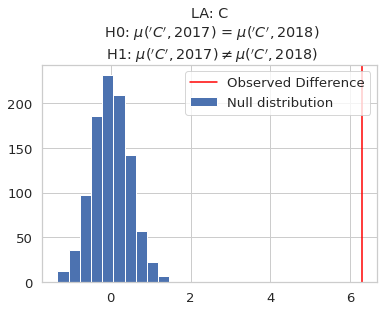

Reject the null hypothesis (H0): p value = 0.001


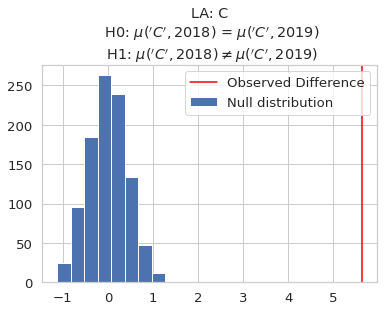

Reject the null hypothesis (H0): p value = 0.001


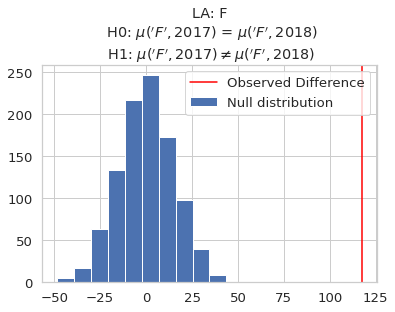

Reject the null hypothesis (H0): p value = 0.001


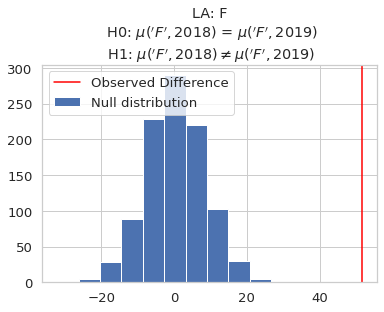

Reject the null hypothesis (H0): p value = 0.001


In [17]:
for drug in ['RS_A','RS_C','RS_F']:
    test(df,'LA',drug,2017,2018)
    test(df,'LA',drug,2018,2019)

The decline in sales of drug A, C, and F is year 2018 and 2019 are significant. 

Lets check if the decline in sale of drug B in 2018 is significant.

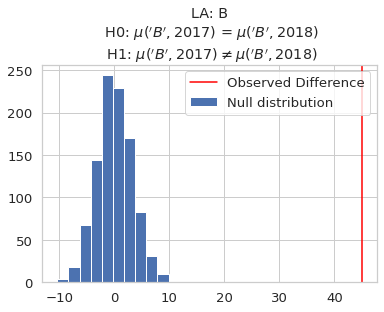

Reject the null hypothesis (H0): p value = 0.001


In [18]:
test(df,'LA','RS_B',2017,2018)

Yes, the sale decline of drug B in 2018 is significant.

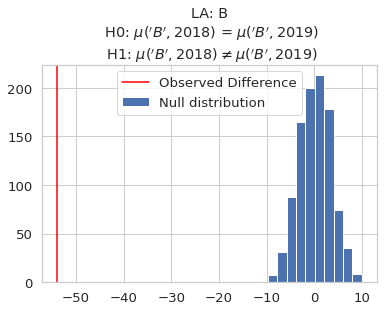

Reject the null hypothesis (H0): p value = 0.001


In [19]:
test(df,'LA','RS_B',2018,2019)

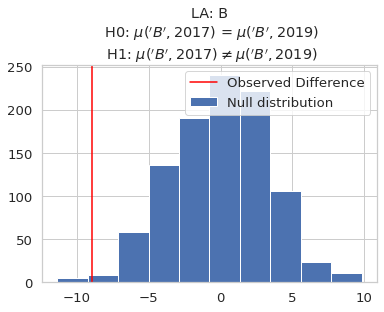

Reject the null hypothesis (H0): p value = 0.008


In [20]:
test(df,'LA','RS_B',2017,2019)

Note that the sale of drug B increased in 2019 and was signifcantly greater than it was in either 2017 or 2018.

## Is sale of a particular drug correlated with another. How does the correlation look for each year?

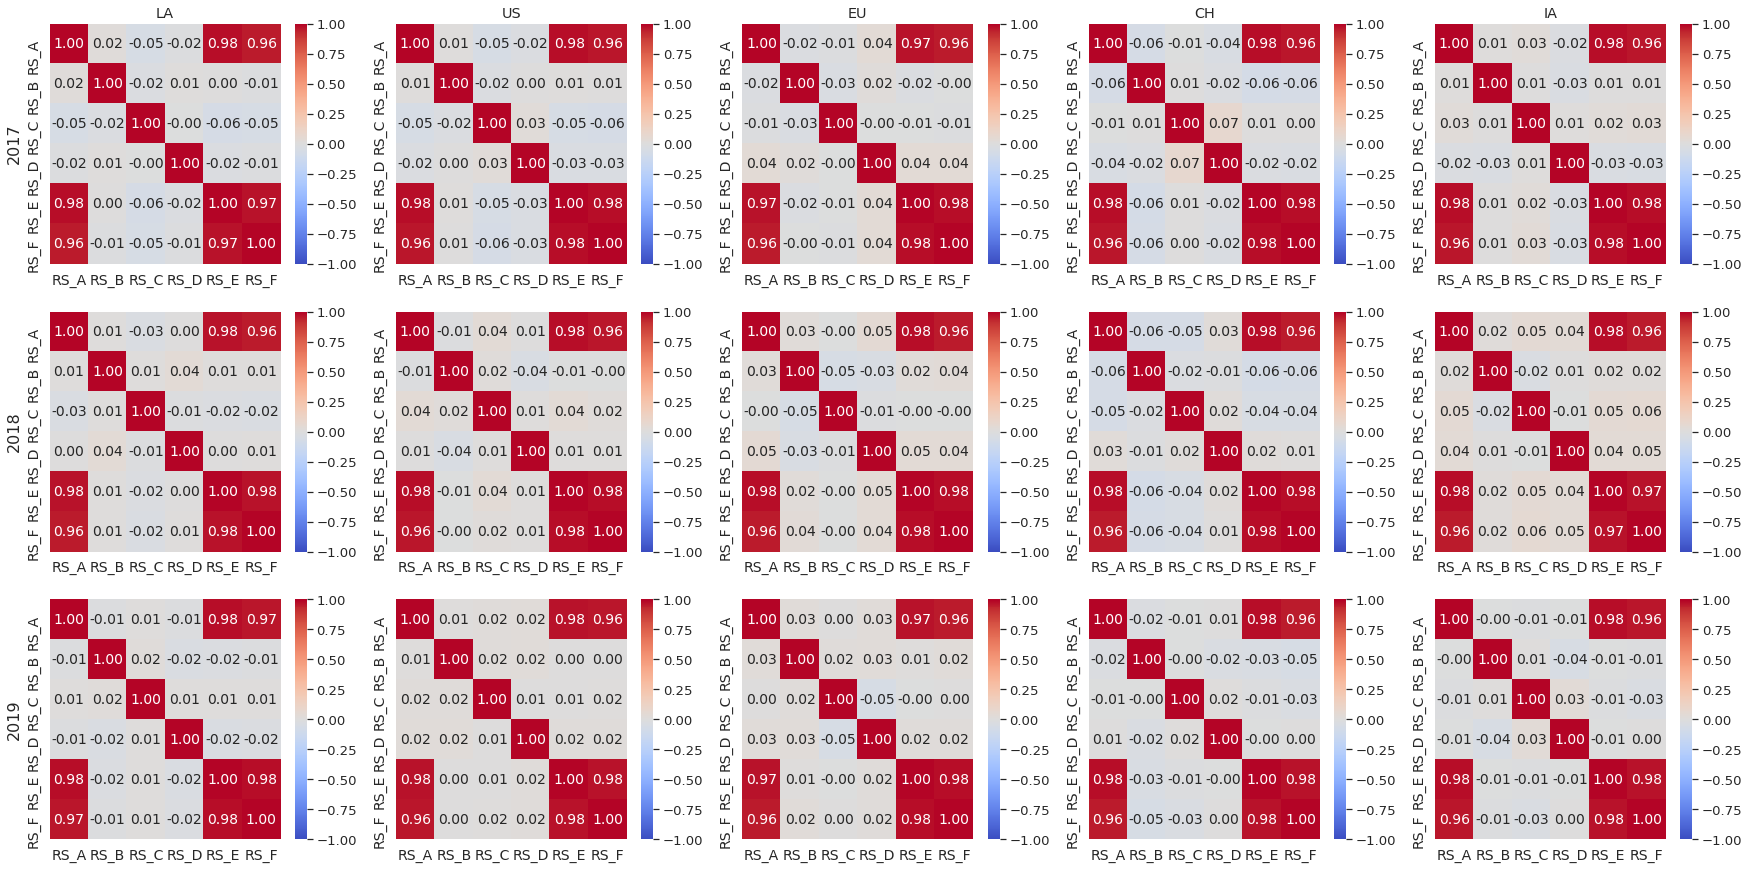

In [21]:
fig, axes = plt.subplots(ncols=5,nrows=3,figsize=(30,15))
fig.subplots_adjust(hspace=0.2)
for j, region in enumerate(df.Region.unique()):
    for i, year in enumerate(df.YEAR.unique()):
        filt_data = data[(data['Region']==region) & (data['YEAR']==year)][[col for col in data.columns if 'RS' in col]]
        sns.heatmap(filt_data.corr(),cmap='coolwarm',vmin=-1,vmax=1,annot=True,annot_kws={'size':14},ax=axes[i,j],fmt='.2f')
        
        if j == 0:
            axes[i,j].set_ylabel(year,fontsize=16)
            
        if i == 0:
            axes[i,j].set_title(region)
            
        axes[i,j].tick_params(axis='both',labelsize= 14)

Sale of drugs A, E and F are highly correlated, but this correlation is consistent acorss years and hence don't tell anythig both sale decline 